## Лабораторна робота №2: "Імплементація алгоритмів стиснення"

# Алгоритм LZ77

In [3]:


class LZ77:
    """LZ77 algorithm implementation"""

    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
 
    def get_compression_rate(self, text) -> float:
        """Return compression rate"""
        return len(text) / len(self.encode(text))

    def encode(self, text: str) -> str:
        """Encode text"""
        encoded_text = []
        i = 0

        while i <= len(text):
            steps, length, unmatched = self._get_longest_sqeuence(text, i)
            encoded_text.append((steps, length, unmatched))
            i+=length+1
        return self.list_to_text(encoded_text)

    def decode(self, code: str) -> str:
        """Decode message in lz77"""
        tuples = self.text_to_list(code)
        decoded = ""
        for (start, length, unmatched) in tuples:
            buffer_start = max(0, len(decoded)-self.buffer_size)
            buffer = decoded[buffer_start:]
            decoded += self._get_cycled_slice(buffer, len(buffer) - start, length)
            if unmatched != '-':
                decoded += unmatched

        return decoded

    @staticmethod
    def list_to_text(encoded_list: list[tuple[int, int, str]]) -> str:
        """Convert encoded list to str"""
        return '\0'.join( f"{lz_tuple[0]}\0{lz_tuple[1]}\0{lz_tuple[2]}" for lz_tuple in encoded_list)

    @staticmethod
    def text_to_list(encoded_text: str) -> list[tuple[int, int, str]]:
        """Convert encoded text to list of tuples"""
        tuples = []
        i = 0

        tuples_text = encoded_text.split('\0')
        for i in range(len(tuples_text) // 3):
            steps, length, unmatched = tuples_text[3*i:3*(i+1)]
            tuples.append((int(steps), int(length), unmatched))

        return tuples

    def _get_longest_sqeuence(self, text: str, i: int) -> tuple[int, int, str]:
        """
        Return tuple of longest sequence from buffer
        :param text str: message to code
        :param i str: index of start of current input
        :return tuple[int, int, str] tuple of match 
        (steps_to_match, number of matched characters, unmathed character)
        """

        buffer_start = max(0, i-self.buffer_size)

        text_input = text[i:]

        if not text_input:
            return (0, 0, '-')

        buffer = text[buffer_start:i]
        searched_sequences = {k: buffer_char for k, buffer_char in enumerate(buffer)\
                             if buffer_char == text_input[0]}
        sequences = []
        for char in text_input[1:]:
            if not searched_sequences:
                break

            new_search = {}
            for k, sequence in searched_sequences.items():
                if buffer[(k+len(sequence)) % len(buffer)] == char:
                    new_search[k] = searched_sequences[k] + char
                else:
                    sequences.append((len(buffer) - k, len(searched_sequences[k]), char))

            searched_sequences = new_search

        for k, sequence in searched_sequences.items():
            sequences.append((len(buffer) - k, len(searched_sequences[k]), '-'))

        if sequences:
            return max(sequences, key=lambda t: t[1])
        else:
            return (0, 0, text_input[0] if text_input else '-')

    @staticmethod
    def _get_cycled_slice(text, start: int, length: int) -> str:
        """
        Return cycled slice of string
        >>> LZ77.get_cycled_slice("12345", 1, 10)
        '2345123451'
        """
        sliced_string = ""
        i = 0
        while len(sliced_string) < length:
            sliced_string += text[(start+i)%len(text)]
            i += 1
        return sliced_string



# Алгоритм Deflate

In [4]:

class Node:
    def __init__(self, value, code = None, left = None, right = None) -> None:
        self.value = value
        self.left_child = left
        self.right_child = right
        self.code = code

class Huffman:

    def encode(self, text: str) -> tuple[str, dict[str, str]]:
        length, output_chance_dict, sorted_dict = len(text), {}, []

        for i in text:
            output_chance_dict.setdefault(i, 0)
            output_chance_dict[i] += 1/length

        sorted_dict = {Node(value, key) for key, value in output_chance_dict.items()}

        sorted_dict = sorted(sorted_dict, key = lambda x: x.value)

        # Build tree

        while len(sorted_dict) > 1:
            sorted_dict.append(Node(sorted_dict[0].value + sorted_dict[1].value, left = sorted_dict.pop(0), right = sorted_dict.pop(0)))
            sorted_dict = sorted(sorted_dict, key = lambda x: x.value)

        # Encode characters

        encoding_dictinary = {}

        def recursive_encode(node:Node, existing_code):
            if node.code is not None:
                encoding_dictinary[node.code] = existing_code
                return
            recursive_encode(node.left_child, existing_code + '0')
            recursive_encode(node.right_child, existing_code + '1')

        recursive_encode(sorted_dict[0], '')
        code =  "".join([encoding_dictinary[i] for i in text])
        return self.to_text(code, encoding_dictinary)

    def decode(self, code: str):
        code, coding_dict = self.from_text(code)
        point_now, number, output = '', 0, ''
        while code:
            point_now += code[number]
            for key, value in coding_dict.items():
                if point_now == value:
                    code = code[number + 1:]
                    number = -1
                    output += key
                    point_now = ''
                    break
            number += 1
        return output
    
    @staticmethod
    def to_text(code: str, dictionary: dict[str, str]) -> str:
        delimeter_code = dictionary['\0']
        del dictionary['\0']
        dictionary_as_str = f"{delimeter_code}\0" + '\0'.join(f"{s}\0{code}" for s, code in dictionary.items())
        return f"{code}\0{dictionary_as_str}"

    @staticmethod
    def from_text(code: str):
        parts = code.split("\0")
        code = parts[0]
        dictionary_parts = parts[2:]
        dictionary = dict( dictionary_parts[2*i:2*(i+1)]  for i in range(0, len(dictionary_parts) // 2))
        dictionary['\0'] = parts[1]
        return code, dictionary
        



In [5]:
class Deflate:
    def __init__(self, buffer_size: int):
        self.huffman = Huffman()
        self.lz77 = LZ77(buffer_size)

    def get_compression_rate(self, text) -> float:
        """Return compression rate"""
        return len(text)*8 / len(self.encode(text))

    def encode(self, text: str) -> str:
        lz77e_encoded = self.lz77.encode(text)
        return self.huffman.encode(lz77e_encoded)

    def decode(self, code: str) -> str:
        huffman_decoded = self.huffman.decode(code)
        return self.lz77.decode(huffman_decoded)
    

### Testing

In [6]:
import time
import string
import random

def generate_random_string(n: int) -> str:
    """Generate random string of n"""
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=n))

Firstly we will test if algorithm can decode correctly what it has encoded. We also will vary buffer size

In [7]:
def test_correctness(algorithm_class):

    for n in range(1, 10000, 500):
        text = generate_random_string(n)
        for buffer_size in range(5, 1000, 200):
            algorithm = algorithm_class(buffer_size)
            decoded_encoded_text = algorithm.decode(algorithm.encode(text))
            assert text.strip() == decoded_encoded_text, str(buffer_size) + " "+  text


In [8]:
test_correctness(Deflate)
test_correctness(LZ77)

Then we must test performance of algorithms

In [9]:
import matplotlib.pyplot as plt

def draw_time_plot(algorithm_class):

    buffer_step = 300
    encoding_by_buffer_sizes = {b:[] for b in range(5, 1000, buffer_step)}
    decocing_by_buffer_sizes = {b:[] for b in range(5, 1000, buffer_step)}
    test_size_range = range(1, 10000, 500)

    for n in test_size_range:
        text = generate_random_string(n)
        for buffer_size in range(5, 1000, buffer_step):
            lz77 = algorithm_class(buffer_size)
            start = time.perf_counter() 
            encoded = lz77.encode(text) 
            encoding_by_buffer_sizes[buffer_size].append(time.perf_counter() - start)
            start = time.perf_counter()
            lz77.decode(encoded)
            decocing_by_buffer_sizes[buffer_size].append(time.perf_counter() - start)
    
    for buffer_size, working_time in encoding_by_buffer_sizes.items():
        plt.plot(test_size_range, working_time, label=f"{buffer_size=}")
        plt.title(f"Encoding performance of {algorithm_class.__name__}")
    plt.legend()
    plt.show()
 
    for buffer_size, working_time in encoding_by_buffer_sizes.items():
        plt.plot(test_size_range, working_time, label=f"{buffer_size=}")
        plt.title(f"Decoding performance of {algorithm_class.__name__}")
    plt.legend()
    plt.show()

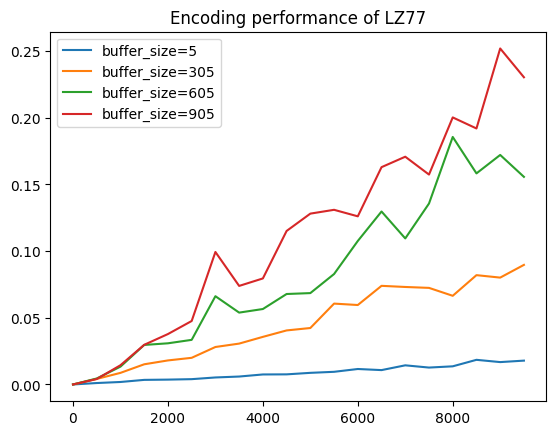

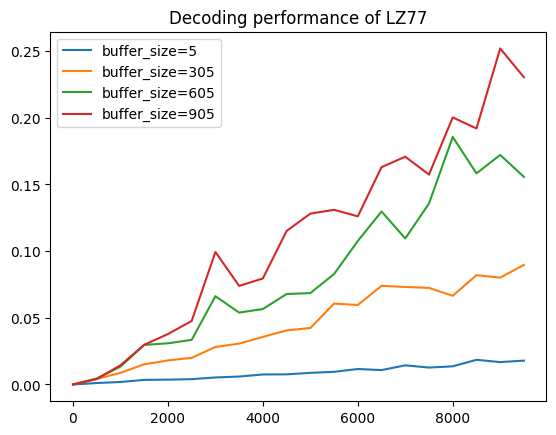

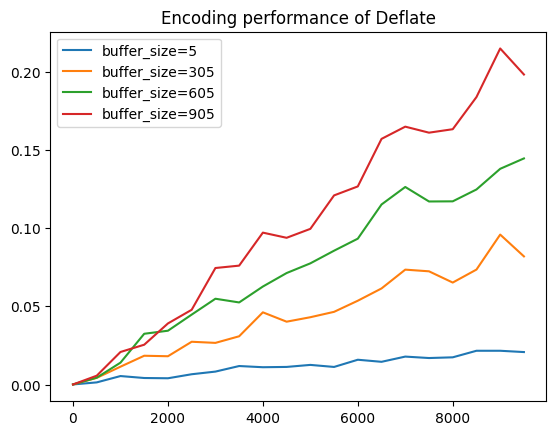

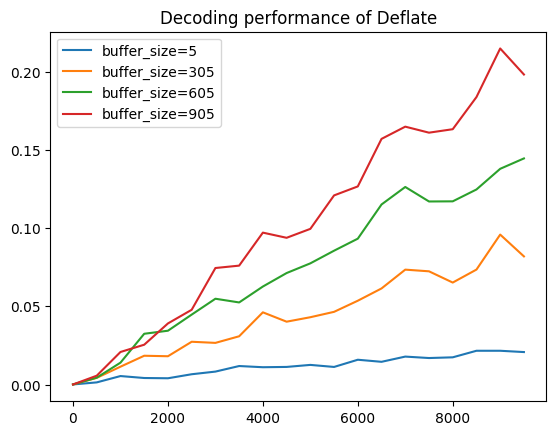

In [10]:
draw_time_plot(LZ77)
draw_time_plot(Deflate)

And, finally, compression rate tests

In [11]:
text = open("eneida.txt", 'r').read()
len(text)

198766

In [14]:

def draw_compression_rate_by_buffer_size(algorith_class):
    """Draw plot of how algorithm compresses data"""

    buffer_size_range = range(10, 10001, 2500)
    compression_rates = [] 

    for buffer_size in buffer_size_range:
        algorithm = algorith_class(buffer_size)
        compression_rates.append(algorithm.get_compression_rate(text))

    plt.plot(buffer_size_range, compression_rates)

    plt.title(f"Compression rate by buffer_size of {algorith_class.__name__}")
    plt.xlabel("Buffer size")
    plt.ylabel("Compression rate")
    plt.title(f"{algorith_class.__name__} compression rate")
    plt.show()


198766 888381
198766 434510
198766 403337
198766 385188


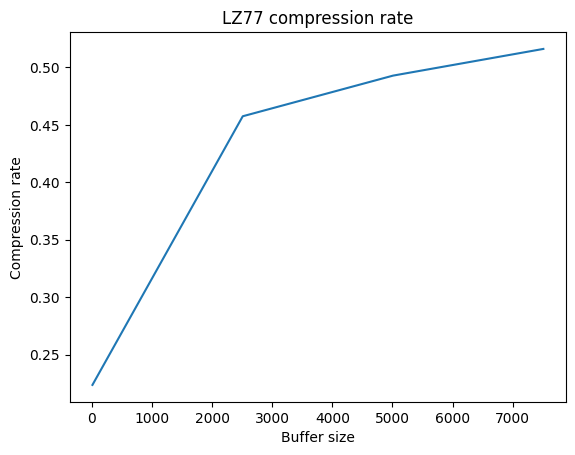

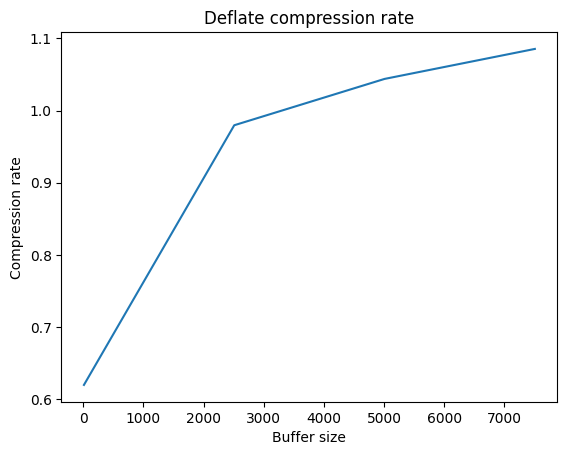

In [15]:
draw_compression_rate_by_buffer_size(LZ77)
draw_compression_rate_by_buffer_size(Deflate)

## Conslusion

We've implemented LZ77 and deflate algorithms.

Although our implementation of Deflate algorithm is not as sophicsticated as in zlib or so, it show the basic stucture after it

As were shown in graph, Deflate algorithm is able to better compress data and it has not big overhead in time consumption, because most of its execution if **LZ77** code.
